# Connect-4 — Supervised Learning (Multiclass Classification)

**Goal**: Predict Player 1 outcome from board state (`win=2, loss=1, tie=0`).  
**What’s inside**: clean EDA → robust baselines → encoder/model comparison with CV → hyperparameter tuning → test evaluation → sensitivity (test size) → conclusions.  
**Reproducibility**: single config cell; fixed seeds; all metrics & plots generated programmatically.
**Metrics**: We report Accuracy and emphasize Macro-F1 due to class imbalance.

## 1) Imports & Set up

In [16]:
# imports
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.base import clone
import matplotlib.pyplot as plt


In [5]:
# load
df = pd.read_csv('../data/raw/connect-4.csv')
print("data size:", df.shape)
df.head()

data size: (67557, 43)


,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,...,f4,f5,f6,g1,g2,g3,g4,g5,g6,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


## 2) Validate (Schema check + EDA)

In [6]:
# schema/lave check
all_cols = df.columns.tolist()
target_col = all_cols[-1]
board_cols = all_cols[:-1]

print("Target column:", target_col)
print("Board columns:", len(board_cols))
print(df[target_col].value_counts())
print("Unique board vals (union):", sorted(set().union(*[set(df[c].unique()) for c in board_cols])))


Target column: target
Board columns: 42
target
2    44473
1    16635
0     6449
Name: count, dtype: int64
Unique board vals (union): [np.int64(0), np.int64(1), np.int64(2)]


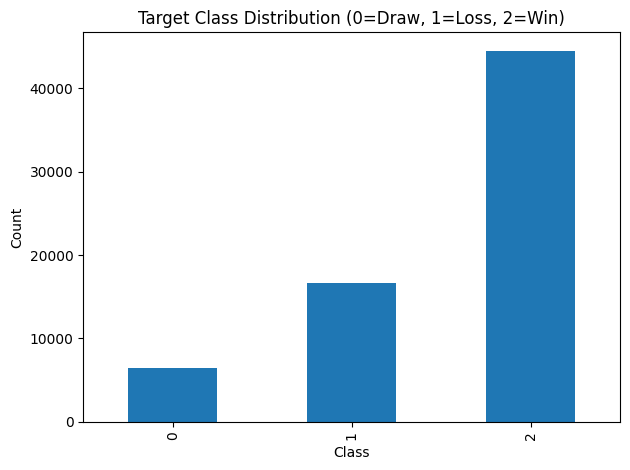

In [7]:
# Target class distribution (imbalance evidence)
ax = df['target'].value_counts().sort_index().plot(kind='bar')
ax.set_title("Target Class Distribution (0=Draw, 1=Loss, 2=Win)")
ax.set_xlabel("Class"); ax.set_ylabel("Count")
plt.tight_layout()
plt.show()


In [8]:
print("Class Ratios (%):", 
      (df['target'].value_counts(normalize=True)*100).round(2).to_dict())


Class Ratios (%): {2: 65.83, 1: 24.62, 0: 9.55}


### class imbalance structure
In this situation, simple Accuracy can come out high even if the model ignores minority classes, so **Macro-F1** was used as a major performance indicator in this task. This is a measure that considers the Recall of each class equally, and is a more valid evaluation method in an unbalanced situation.

In [9]:
# missing/duplicate
print("Total missing values:", df.isna().sum().sum())

dup_count = df.duplicated().sum()
print("Total duplicated rows:", dup_count)

df = df.drop_duplicates()
print("Shape after dropping duplicates:", df.shape)


Total missing values: 0
Total duplicated rows: 0
Shape after dropping duplicates: (67557, 43)


- **No missing data** → no imputation required.
- **No feature removal** → spatial positions are meaningful strategy features.
- **One-Hot Encoding** → appropriate for categorical non-ordinal board representations.


## 3) Split & Baseline

In [10]:
# train/test split (stratify)
X, y = df[board_cols], df['target']
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print("Train class dist:", y_tr.value_counts(normalize=True).sort_index().round(3).to_dict())
print("Test  class dist:", y_te.value_counts(normalize=True).sort_index().round(3).to_dict())


Train class dist: {0: 0.095, 1: 0.246, 2: 0.658}
Test  class dist: {0: 0.095, 1: 0.246, 2: 0.658}


In [11]:
# Dummy baseline (most_frequent)
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_tr, y_tr)
y_pred = dummy.predict(X_te)
print('Dummy Accuracy:', accuracy_score(y_te, y_pred))
print('Dummy macro-F1:', f1_score(y_te, y_pred, average='macro'))


Dummy Accuracy: 0.6583185316755477
Dummy macro-F1: 0.2646530281933188


## 4) Encoders & Model Registry


In [12]:
# two preprocessors
prep_onehot = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), board_cols)], remainder='drop')
# for control experiments
prep_numeric = 'passthrough' 


In [17]:
models = {
    "LogReg (onehot)": Pipeline([('prep', prep_onehot), ('clf', LogisticRegression(max_iter=1000, multi_class='multinomial'))]),
    "DecisionTree (onehot)": Pipeline([('prep', prep_onehot), ('clf', DecisionTreeClassifier(random_state=42))]),
    "RandomForest (onehot)": Pipeline([('prep', prep_onehot), ('clf', RandomForestClassifier(n_estimators=200, random_state=42))]),
    "LogReg (numeric)": Pipeline([('prep', prep_numeric), ('clf', LogisticRegression(max_iter=1000, multi_class='multinomial'))]),
    "DecisionTree (numeric)": Pipeline([('prep', prep_numeric), ('clf', DecisionTreeClassifier(random_state=42))]),
    "RandomForest (numeric)": Pipeline([('prep', prep_numeric), ('clf', RandomForestClassifier(n_estimators=200, random_state=42))]),
}

In [22]:
models = {
    "LogReg (onehot)": Pipeline([
        ('prep', prep_onehot),
        ('clf', LogisticRegression(max_iter=1000, solver='lbfgs'))  # multi_class 제거
    ]),
    "DecisionTree (onehot)": Pipeline([
        ('prep', prep_onehot),
        ('clf', DecisionTreeClassifier(random_state=42))
    ]),
    "RandomForest (onehot)": Pipeline([
        ('prep', prep_onehot),
        ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
    ]),
    "LogReg (numeric)": Pipeline([
        ('prep', prep_numeric),
        ('clf', LogisticRegression(max_iter=1000, solver='lbfgs'))  # multi_class 제거
    ]),
    "DecisionTree (numeric)": Pipeline([
        ('prep', prep_numeric),
        ('clf', DecisionTreeClassifier(random_state=42))
    ]),
    "RandomForest (numeric)": Pipeline([
        ('prep', prep_numeric),
        ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
    ]),
}


The board values in Connect-4 represent **categorical states with no inherent order**.  
If Label Encoding is used, the model may incorrectly assume a relationship such as `2 > 1 > 0`,  
which **does not reflect any real semantic ordering** in the game.

In contrast, **One-Hot Encoding** separates each state into its own feature,  
**making it explicit that no ordinal relationship exists among the categories.**


## 5) Cross-Validation Comparison

In [23]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []
for name, pipe in models.items():
    cv = cross_validate(
        pipe, X, y, cv=skf,
        scoring={'acc':'accuracy', 'f1':'f1_macro'},
        n_jobs=-1, return_train_score=False
    )
    scores.append({
        "Model": name,
        "CV Acc (mean)": cv['test_acc'].mean(),
        "CV Acc (std)": cv['test_acc'].std(),
        "CV Macro-F1 (mean)": cv['test_f1'].mean(),
        "CV Macro-F1 (std)": cv['test_f1'].std()
    })

cv_df = pd.DataFrame(scores).sort_values("CV Macro-F1 (mean)", ascending=False)
cv_df


,Model,CV Acc (mean),CV Acc (std),CV Macro-F1 (mean),CV Macro-F1 (std)
2,RandomForest (onehot),0.831091,0.003373,0.630179,0.005256
1,DecisionTree (onehot),0.762497,0.002822,0.610243,0.002277
5,RandomForest (numeric),0.815933,0.001372,0.607648,0.003440
4,DecisionTree (numeric),0.734136,0.002688,0.576216,0.002814
0,LogReg (onehot),0.757301,0.002026,0.500781,0.002377
3,LogReg (numeric),0.660923,0.000281,0.283522,0.001163


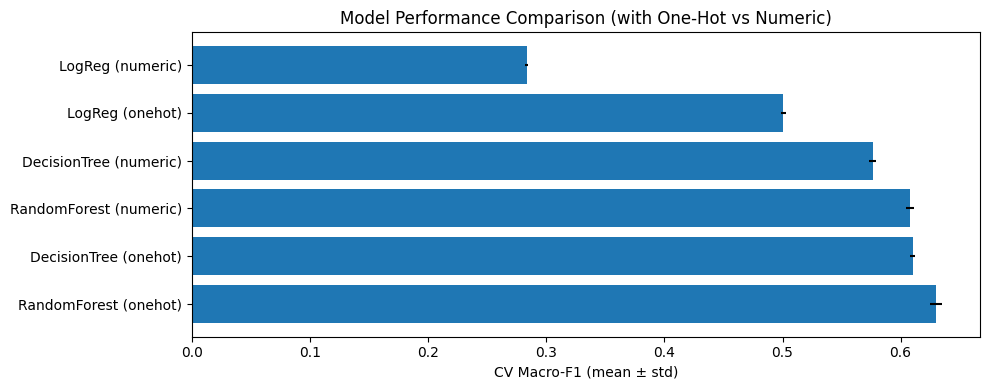

In [24]:
plt.figure(figsize=(10,4))
plt.barh(cv_df['Model'],
         cv_df['CV Macro-F1 (mean)'],
         xerr=cv_df['CV Macro-F1 (std)'])
plt.xlabel("CV Macro-F1 (mean ± std)")
plt.title("Model Performance Comparison (with One-Hot vs Numeric)")
plt.tight_layout()
plt.show()


## 6) Hyperparameter Tuning

In [27]:
# RandomForest
rf_grid = {
    'clf__n_estimators': [200, 400],
    'clf__max_depth': [None, 12, 20], # To explore overfitting/underfitting
    'clf__min_samples_leaf': [1, 3, 5]
}
rf_pipe = Pipeline([('prep', prep_onehot), ('clf', RandomForestClassifier(random_state=42, n_estimators=200, n_jobs=1))])
rf_gs = GridSearchCV(rf_pipe, rf_grid, scoring='f1_macro', cv=skf, n_jobs=2, pre_dispatch='2*n_jobs', error_score='raise')
rf_gs.fit(X_tr, y_tr)
print("RF best params:", rf_gs.best_params_, " | best CV f1_macro:", rf_gs.best_score_)

# LogisticRegression
log_grid = {'clf__C': [0.5, 1.0, 2.0]} # weak, moderate, strong
log_pipe = Pipeline([('prep', prep_onehot), ('clf', LogisticRegression(max_iter=1000, solver='lbfgs'))])
log_gs = GridSearchCV(log_pipe, log_grid, scoring='f1_macro', cv=skf, n_jobs=2)
log_gs.fit(X_tr, y_tr)
print("LogReg best params:", log_gs.best_params_, " | best CV f1_macro:", log_gs.best_score_)


/Users/gwonnahyeong/miniforge3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RF best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200}  | best CV f1_macro: 0.6159210171171282
LogReg best params: {'clf__C': 2.0}  | best CV f1_macro: 0.5032695427644758


In [28]:
# RF grid results table (Top 10)
rf_res = pd.DataFrame(rf_gs.cv_results_)
cols = ['param_clf__n_estimators','param_clf__max_depth','param_clf__min_samples_leaf','mean_test_score','std_test_score']
display(rf_res[cols].sort_values('mean_test_score', ascending=False).head(10))


,param_clf__n_estimators,param_clf__max_depth,param_clf__min_samples_leaf,mean_test_score,std_test_score
0,200,None,1,0.615921,0.003454
1,400,None,1,0.615781,0.002352
12,200,20,1,0.577076,0.003523
13,400,20,1,0.576723,0.003312
2,200,None,3,0.549150,0.004344
3,400,None,3,0.548400,0.003676
14,200,20,3,0.537987,0.004124
15,400,20,3,0.537352,0.004055
4,200,None,5,0.528367,0.005333
5,400,None,5,0.527008,0.004795


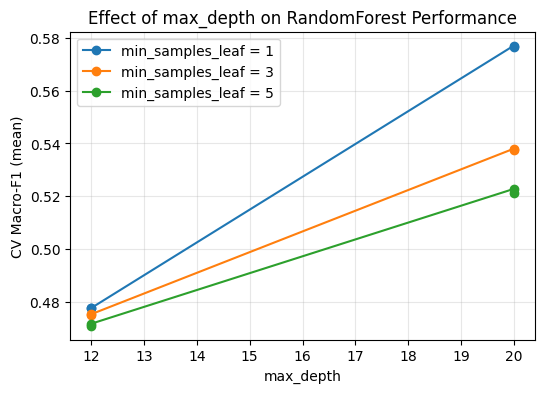

In [37]:
rf_res = pd.DataFrame(rf_gs.cv_results_)

plt.figure(figsize=(6,4))
for leaf in sorted(rf_res["param_clf__min_samples_leaf"].unique()):
    sub = rf_res[rf_res["param_clf__min_samples_leaf"] == leaf]
    plt.plot(
        sub["param_clf__max_depth"],
        sub["mean_test_score"],
        marker='o',
        label=f"min_samples_leaf = {leaf}"
    )

plt.xlabel("max_depth")
plt.ylabel("CV Macro-F1 (mean)")
plt.title("Effect of max_depth on RandomForest Performance")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 7) Final Model Selection & Test Evaluation

In [29]:
best_est, best_name, best_cv = (
    (rf_gs.best_estimator_, "RF(onehot)", rf_gs.best_score_) 
    if rf_gs.best_score_ >= log_gs.best_score_ 
    else (log_gs.best_estimator_, "LogReg(onehot)", log_gs.best_score_)
)

print("Selected:", best_name, "| CV f1_macro:", best_cv)


Selected: RF(onehot) | CV f1_macro: 0.6159210171171282


In [30]:
if hasattr(best_est, "get_params"):
    # inside of pipeline
    final_clf = best_est.named_steps.get('clf', best_est)
    print("Final best params:", final_clf.get_params())


Final best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [31]:
best_est.fit(X_tr, y_tr)
y_hat = best_est.predict(X_te)

print("Test Accuracy:", accuracy_score(y_te, y_hat))
print("Test Macro-F1:", f1_score(y_te, y_hat, average='macro'))
print(classification_report(y_te, y_hat, digits=4))

Test Accuracy: 0.8328004736530491
Test Macro-F1: 0.6325574911543822
              precision    recall  f1-score   support

           0     0.5861    0.1309    0.2140      1612
           1     0.8277    0.7439    0.7836      4159
           2     0.8412    0.9678    0.9001     11119

    accuracy                         0.8328     16890
   macro avg     0.7517    0.6142    0.6326     16890
weighted avg     0.8136    0.8328    0.8059     16890



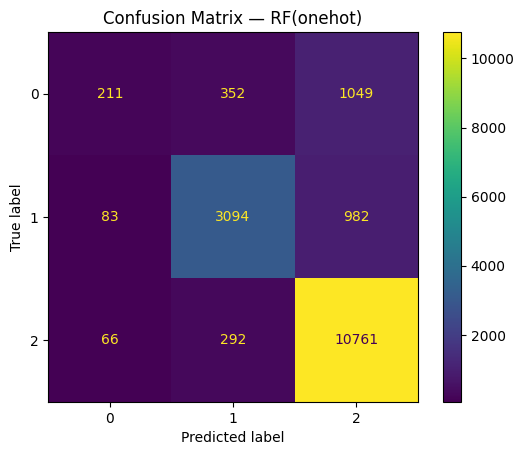

In [32]:
ConfusionMatrixDisplay.from_predictions(y_te, y_hat)
plt.title(f"Confusion Matrix — {best_name}")
plt.show()


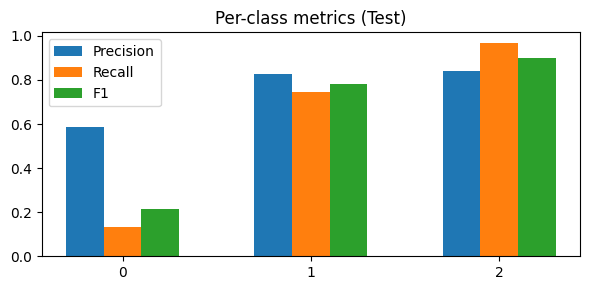

Support: {0: np.int64(1612), 1: np.int64(4159), 2: np.int64(11119)}


In [33]:
# Requires y_te and y_hat defined in prior cells
prec, rec, f1, sup = precision_recall_fscore_support(y_te, y_hat, labels=[0,1,2], zero_division=0)
cls = np.array([0,1,2])

plt.figure(figsize=(6,3))
plt.bar(cls-0.2, prec, width=0.2, label='Precision')
plt.bar(cls,     rec,  width=0.2, label='Recall')
plt.bar(cls+0.2, f1,   width=0.2, label='F1')
plt.xticks(cls)
plt.legend()
plt.title("Per-class metrics (Test)")
plt.tight_layout()
plt.show()

print("Support:", dict(zip([0,1,2], sup)))


## 8) Sensitivity: Train/Test Split difference

In [34]:
# final templete
try:
    if best_name.startswith("RF"):
        final_template = Pipeline([
            ('prep', prep_onehot),
            ('clf', RandomForestClassifier(
                random_state=42,
                **{k.split('__')[1]: v for k, v in rf_gs.best_params_.items()}
            ))
        ])
    else:
        final_template = Pipeline([
            ('prep', prep_onehot),
            ('clf', LogisticRegression(
                max_iter=1000, multi_class='multinomial', random_state=42,
                **{k.split('__')[1]: v for k, v in log_gs.best_params_.items()}
            ))
        ])
except NameError as e:
    raise RuntimeError(
        "This cell expects variables from previous steps: best_name, rf_gs, log_gs, prep_onehot, X, y. "
        "Please run the tuning & selection cells first."
    ) from e


In [35]:
# calculate mean ± standard deviation by iterative partition
seeds = [42, 123, 777]
test_sizes = [0.20, 0.25, 0.30, 0.40]

rows = []
for ts in test_sizes:
    accs, f1s = [], []
    for sd in seeds:
        sss = StratifiedShuffleSplit(n_splits=1, test_size=ts, random_state=sd)
        (tr_idx, te_idx), = sss.split(X, y)
        X_tr2, X_te2 = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr2, y_te2 = y.iloc[tr_idx], y.iloc[te_idx]

        model = clone(final_template)
        model.fit(X_tr2, y_tr2)
        pred = model.predict(X_te2)
        accs.append(accuracy_score(y_te2, pred))
        f1s.append(f1_score(y_te2, pred, average='macro'))

    rows.append({
        "Model": best_name,
        "Test Size": ts,
        "Accuracy (mean)": float(np.mean(accs)),
        "Accuracy (std)":  float(np.std(accs)),
        "Macro-F1 (mean)": float(np.mean(f1s)),
        "Macro-F1 (std)":  float(np.std(f1s)),
    })

sens_df = pd.DataFrame(rows)
display(sens_df)


,Model,Test Size,Accuracy (mean),Accuracy (std),Macro-F1 (mean),Macro-F1 (std)
0,RF(onehot),0.20,0.831977,0.002271,0.631886,0.004773
1,RF(onehot),0.25,0.830827,0.001620,0.630660,0.001962
2,RF(onehot),0.30,0.828432,0.000484,0.624971,0.001248
3,RF(onehot),0.40,0.825852,0.000842,0.620579,0.000911


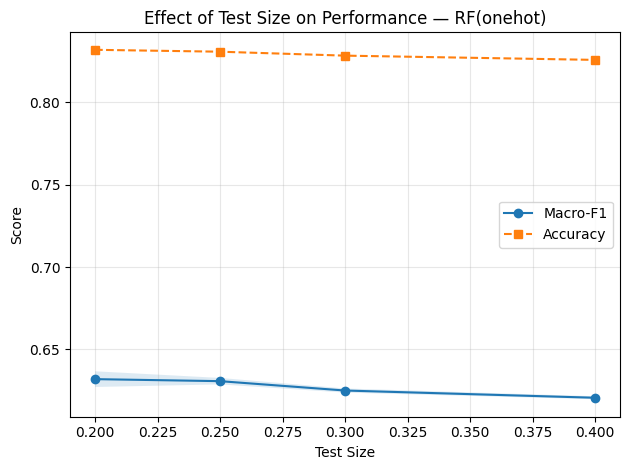

In [36]:
plt.figure()
plt.plot(sens_df["Test Size"], sens_df["Macro-F1 (mean)"], marker='o', label="Macro-F1")
plt.fill_between(
    sens_df["Test Size"],
    sens_df["Macro-F1 (mean)"] - sens_df["Macro-F1 (std)"],
    sens_df["Macro-F1 (mean)"] + sens_df["Macro-F1 (std)"],
    alpha=0.15
)
plt.plot(sens_df["Test Size"], sens_df["Accuracy (mean)"], marker='s', linestyle='--', label="Accuracy")
plt.xlabel("Test Size"); plt.ylabel("Score")
plt.title(f"Effect of Test Size on Performance — {best_name}")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()


## Discussion
This experiment dealt with the multiple classification problem of predicting the result of Player 1 with Connect-4 game status as input.
The data has a state of {0=empty, 1=Player1, 2=Player2}, which consists of **unordered categorical features**.

As a result of comparing the encoding strategy, **One-Hot Encoding** provided the most stable performance.
Label Encoding risked causing the model to mislearn **non-existent orders such as '2 > 1 > 0'
This has been shown to be particularly performance degradation in logistic regression and other linear models.

Model comparisons show that **RandomForest achieves the highest Macro-F1**.
This means that Connect-4 data contains a **non-linear interaction pattern**,
This is because tree-based models **have strengths** in learning these complex rules.

The class distribution was also unbalanced,
Instead of Accuracy, the **Macro-F1 score was used as a key comparison indicator**.
This choice was appropriate for a balanced assessment of the predictive performance of each class.

In summary,

- **One-Hot** is a representation method that matches data characteristics
- **RandomForest** has learned the nonlinear structure and interaction patterns well
- **Logistic Regression** had a small performance improvement due to its limited structural expressiveness.

Therefore, it was confirmed that model selection should be based on the structural nature** of the **data.

## Conclusion
In this project, we compared different encoding schemes and models for Connect-4 game outcome prediction.
As a result of the experiment, the **One-Hot Encoding + Random Forest** combination showed the highest performance and was selected as the final model.

This means that Connect-4 data consists of **unordered categorical information** and **complicated locational patterns**,
This means that **Non-linear tree-based models** are more suitable than linear models.

In addition, the performance evaluation of the model was performed based on the **Macro-F1 score to reflect the data imbalance problem**.
This approach provided more valid performance comparisons than simple accuracy.

In conclusion, **A single model may not always be optimal**,
**It was confirmed that expression (encoding) and model selection that fit the characteristics and structural patterns of the data are key**.